# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

/Users/cgalbeaza/Personal/Facultate/Licenta/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Utils

In [2]:


def load_data(ticker="^GSPC", start_date='1990-01-02', end_date='2024-03-20', split_date='2023-01-01', apply_filter=False, debug=False):
    """ Load data, perform forward fill, optionally apply a Butterworth filter, and split into train and test. """
    # Download historical data from Yahoo Finance
    df = yf.download(ticker, start=start_date, end=end_date)['Close']
    
    # Fill missing values and ensure all business days are accounted for
    all_business_days = pd.date_range(start=start_date, end=end_date, freq='B')
    df = df.reindex(all_business_days).ffill()  # Forward filling the missing values
    if apply_filter:
        df = apply_butterworth_filter(df, debug=debug)

    if debug:
        print(f"Data loaded and forward filled. Total rows after forward fill: {len(df)}.")

    # Split the data into train and test sets
    split_point = pd.Timestamp(split_date)
    train_series = df[df.index < split_point]
    test_series = df[df.index >= split_point]
    return train_series, test_series

def apply_butterworth_filter(series, order=3, critical_frequency=0.05, debug=False):
    """ Applies Butterworth filter to a given pandas Series. """
    b, a = butter(order, critical_frequency, btype='low', analog=False)
    filtered_values = filtfilt(b, a, series)
    filtered_series = pd.Series(filtered_values, index=series.index)
    if debug:
        print("Butterworth filter applied.")
    return filtered_series

def train_sarimax(train_series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)):
    """ Train a SARIMAX model on the provided training data. """
    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    return results

def generate_predictions(model, start, end):
    """ Generate predictions using the trained SARIMAX model. """
    predictions = model.predict(start=start, end=end, typ='levels')
    return predictions

def plot_predictions(test_series, prediction, title=""):
    plt.figure(figsize=(12, 6))
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_full_series(train_series, test_series, prediction, title=""):
    """ Plot the training data, test data, and SARIMAX predictions. """
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Train')
    plt.plot(test_series.index, test_series, label='Test')
    plt.plot(prediction.index, prediction, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


✅ Zero-phase Butterworth filter applied.
Data loaded and forward filled. Total rows after forward fill: 8927.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50373D+00    |proj g|=  5.41292D-01


 This problem is unconstrained.



At iterate    5    f= -1.31436D+00    |proj g|=  7.01747D+00

At iterate   10    f= -1.49885D+00    |proj g|=  1.67097D-01

At iterate   15    f= -1.53437D+00    |proj g|=  5.25692D-01

At iterate   20    f= -1.53695D+00    |proj g|=  6.81993D-01

At iterate   25    f= -1.53816D+00    |proj g|=  2.03832D-02

At iterate   30    f= -1.53825D+00    |proj g|=  3.06083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     95      1     0     0   2.748D-03  -1.538D+00
  F =  -1.5382477568156834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
MSE: 18208.71586986806


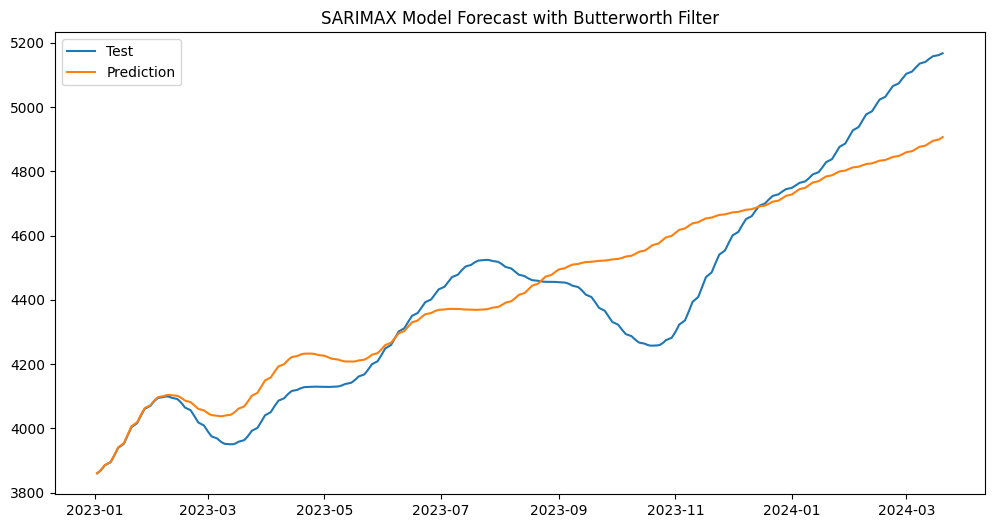

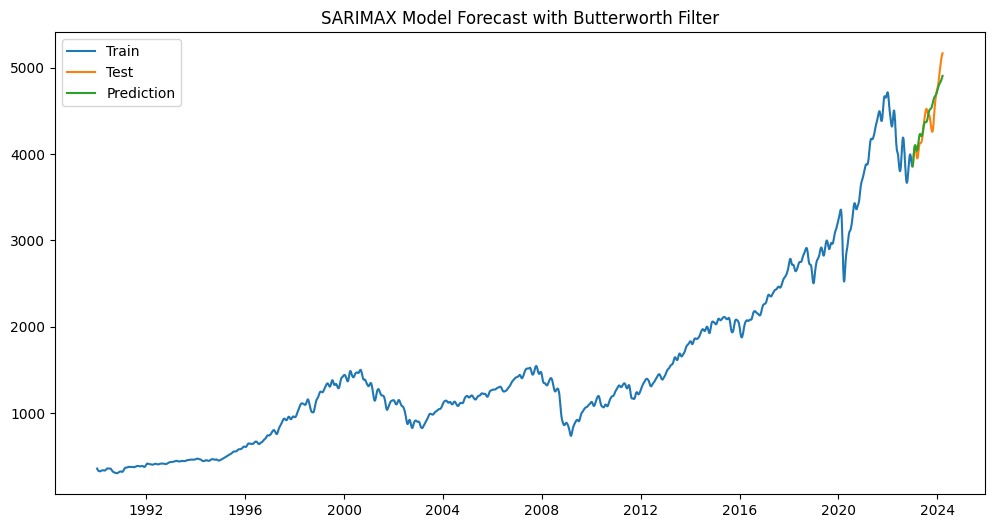

In [4]:
# Load and preprocess the data
train_series, test_series = load_data(apply_filter=True, debug=True)

# Train the SARIMAX model
model = train_sarimax(train_series, order=(0,1,3), seasonal_order=(2,1,0,5))

# Generate predictions
predictions = generate_predictions(model, start=test_series.index[0], end=test_series.index[-1])

# Calculate the mean squared error
error = mean_squared_error(test_series, predictions)
print(f"MSE: {error}")

# Plot the results
plot_predictions(test_series, predictions, title="SARIMAX Model Forecast with Butterworth Filter")
plot_full_series(train_series, test_series, predictions, title="SARIMAX Model Forecast with Butterworth Filter")
